## Q 2 K means 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X = np.loadtxt("Dataset2-Assignment 1 - Dataset.csv", delimiter=",")
n,d = X.shape

In [3]:
X.shape

(1000, 2)

### x1 and x2 are features of dataset 

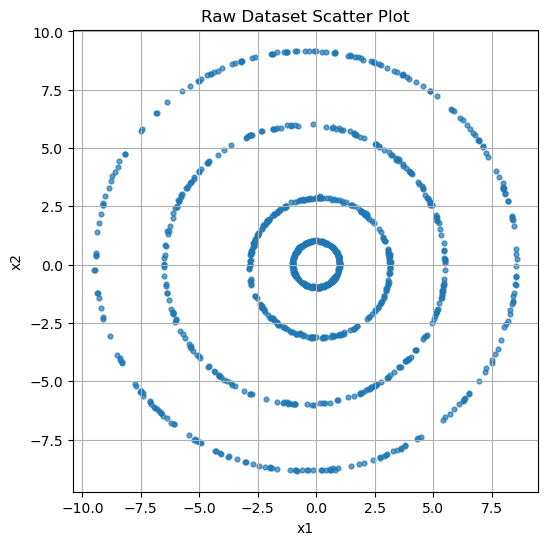

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], s=12, alpha=0.7)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Raw Dataset Scatter Plot")
plt.grid(True)
plt.show()

In [5]:
def squared_euclidean(A, B):
    AA = np.sum(A**2, axis=1)[:, None]
    BB = np.sum(B**2, axis=1)[None, :]
    
    AB = A @ B.T
    D2 = AA + BB - 2*AB
    D2[D2 < 0] = 0.0
    return D2

In [6]:
# K-means 
def kmeans(X, k, init_centers=None, max_iter=300, tol=1e-6, seed=None):
    rng = np.random.default_rng(seed)
    n, d = X.shape
    if init_centers is None:
        idx = rng.choice(n, k, replace=False)
        centers = X[idx].astype(float)
    else:
        centers = np.array(init_centers, dtype=float)

    inertia_hist = []
    labels = np.zeros(n, dtype=int)
    for _ in range(max_iter):
        D2 = squared_euclidean(X, centers)
        labels = np.argmin(D2, axis=1)
        inertia = np.sum(np.min(D2, axis=1))
        inertia_hist.append(inertia)

        new_centers = np.zeros_like(centers)
        for j in range(k):
            pts = X[labels == j]
            if pts.shape[0] == 0:
                new_centers[j] = X[rng.integers(0, n)]
            else:
                new_centers[j] = np.mean(pts, axis=0)

        shift = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if shift < tol:
            break

    return centers, labels, inertia_hist


In [7]:
def rbf_kernel(X, sigma):
    D2 = squared_euclidean(X, X)
    return np.exp(-D2 / (2.0 * sigma**2))

In [8]:
# Median heuristic for sigma
def median_distance(X):
    n = X.shape[0]
    D2 = squared_euclidean(X, X)
    i, j = np.triu_indices(n, k=1)
    return np.median(np.sqrt(D2[i, j]))

In [9]:
def plot_clusters(ax, X, labels, centers=None, title=None):
    unique = np.unique(labels)
    for lab in unique:
        pts = X[labels == lab]
        ax.scatter(pts[:,0], pts[:,1], s=18, label=f"C{lab+1}", alpha=0.85)
    if centers is not None:
        ax.scatter(centers[:,0], centers[:,1], s=90, marker='X', c='black')
    ax.set_xlabel("x1"); ax.set_ylabel("x2")
    if title: ax.set_title(title)
    ax.legend(fontsize='small'); ax.grid(True)

In [10]:
def plot_voronoi_like(ax, X, centers, labels, title=None, grid_res=300):
    xmin, ymin = X.min(axis=0) - 0.5
    xmax, ymax = X.max(axis=0) + 0.5
    xs = np.linspace(xmin, xmax, grid_res)
    ys = np.linspace(ymin, ymax, grid_res)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.c_[xx.ravel(), yy.ravel()]
    Dg = squared_euclidean(grid, centers)
    grid_labels = np.argmin(Dg, axis=1).reshape(xx.shape)
    ax.contourf(xx, yy, grid_labels, alpha=0.25, cmap='tab10',
                levels=np.arange(-0.5, centers.shape[0]+0.5, 1))
    plot_clusters(ax, X, labels, centers, title)

## Q2(a)

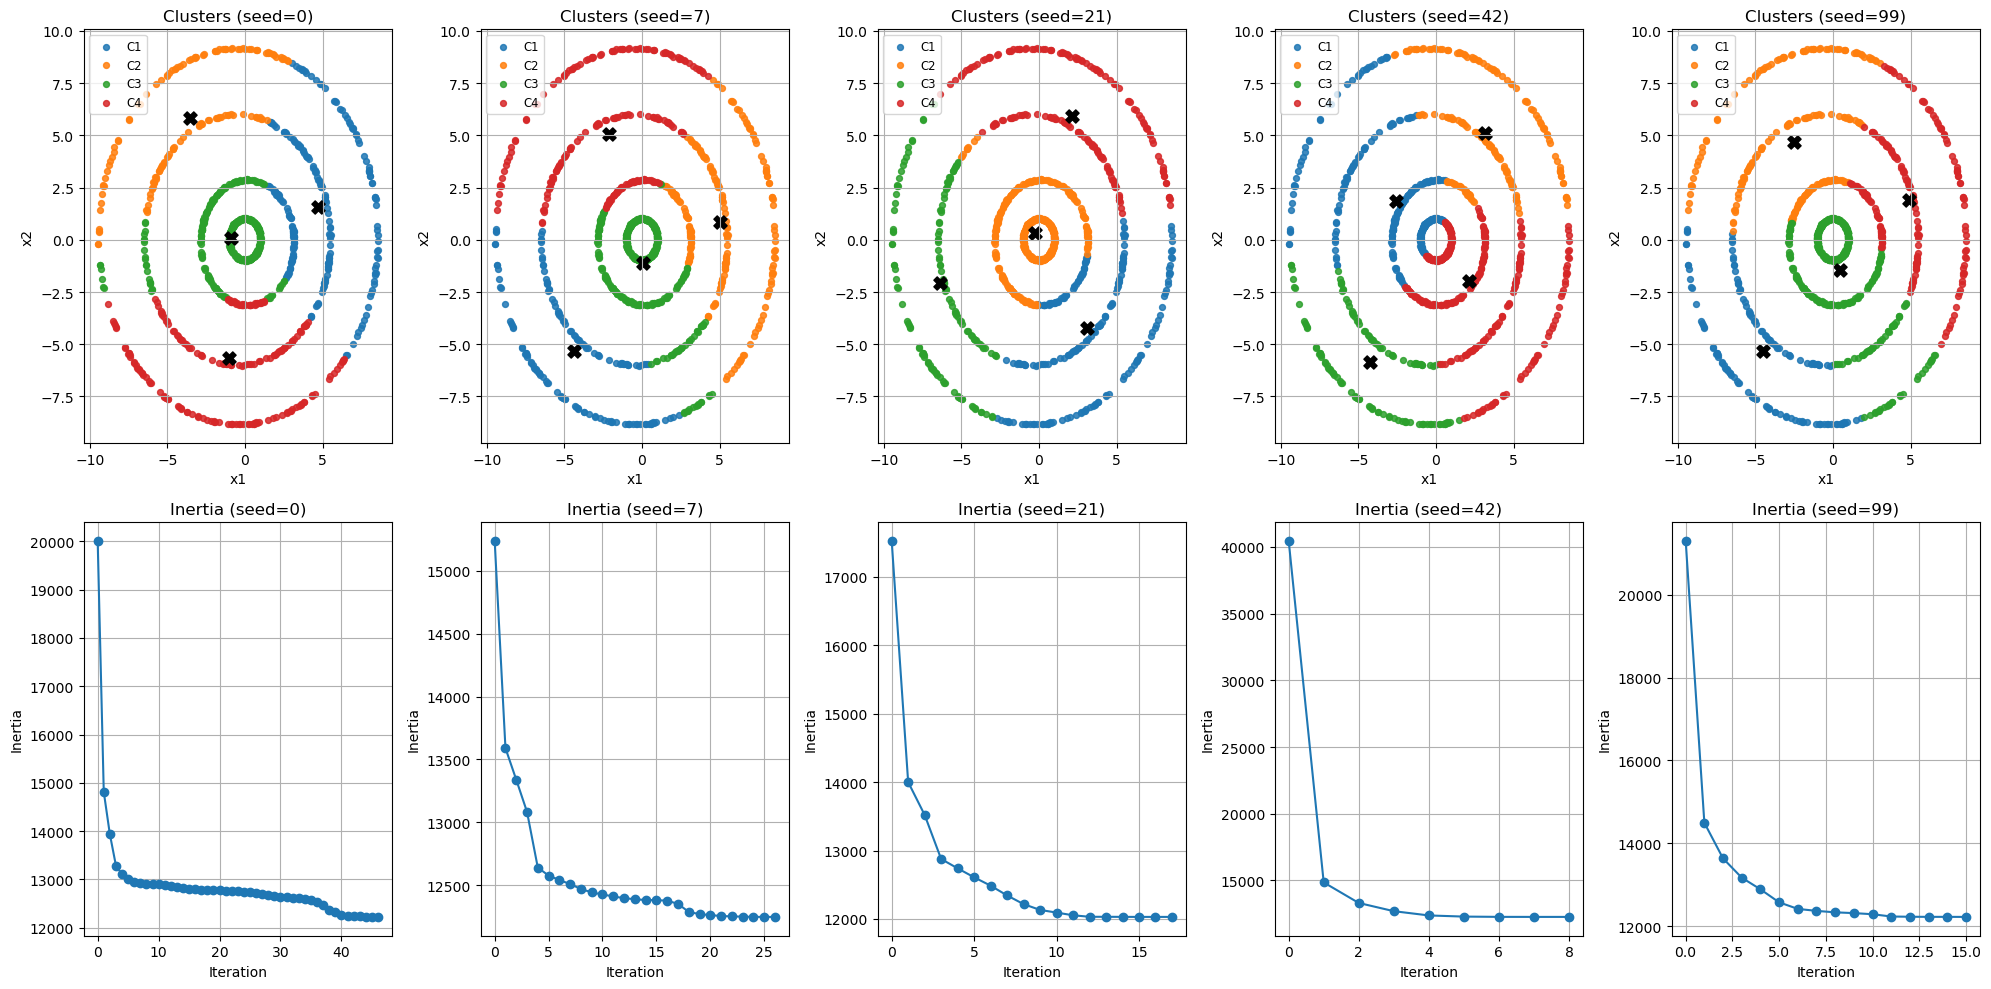

In [11]:
k = 4
seeds = [0, 7, 21, 42, 99]

# (top = clusters, bottom = inertia)
fig, axes = plt.subplots(2, len(seeds), figsize=(4*len(seeds), 10))

for i, seed in enumerate(seeds):
    np.random.seed(seed)
    idx = np.random.choice(n, k, replace=False)
    centers, labels, inertia_hist = kmeans(X, k, init_centers=X[idx])

    # clusters
    ax_top = axes[0, i]
    plot_clusters(ax_top, X, labels, centers, title=f"Clusters (seed={seed})")

    # inertia vs iterations
    ax_bot = axes[1, i]
    ax_bot.plot(inertia_hist, marker='o')
    ax_bot.set_xlabel("Iteration"); ax_bot.set_ylabel("Inertia")
    ax_bot.set_title(f"Inertia (seed={seed})")
    ax_bot.grid(True)

plt.tight_layout()
plt.show()


## Part (a): K-Means with Varying Initializations

- In every run, inertia drops sharply at first then levels off → K-Means converges quickly.  
- The resulting clusters depend strongly on the initialization (random seeds).  

### Observations
- **Seed 0:** Slow convergence (~40 iters), rings separated but not very clean.  
- **Seed 7:** Faster (~25 iters), inner rings look good, outer edges a bit messy.  
- **Seed 21:** (~15 iters) balanced, inner rings clear, outer ones somewhat mixed.  
- **Seed 42:** Very quick (~8 iters), rings cleanly split, centers well placed.  
- **Seed 99:** (~15 iters) stable and neat, similar to seed 42.  

### Takeaway
K-Means is quite sensitive to initialization. Some seeds (42, 99) give clean results, while others take longer or produce weaker splits. Running multiple restarts is essential for the best outcome.  

## Q2(b)

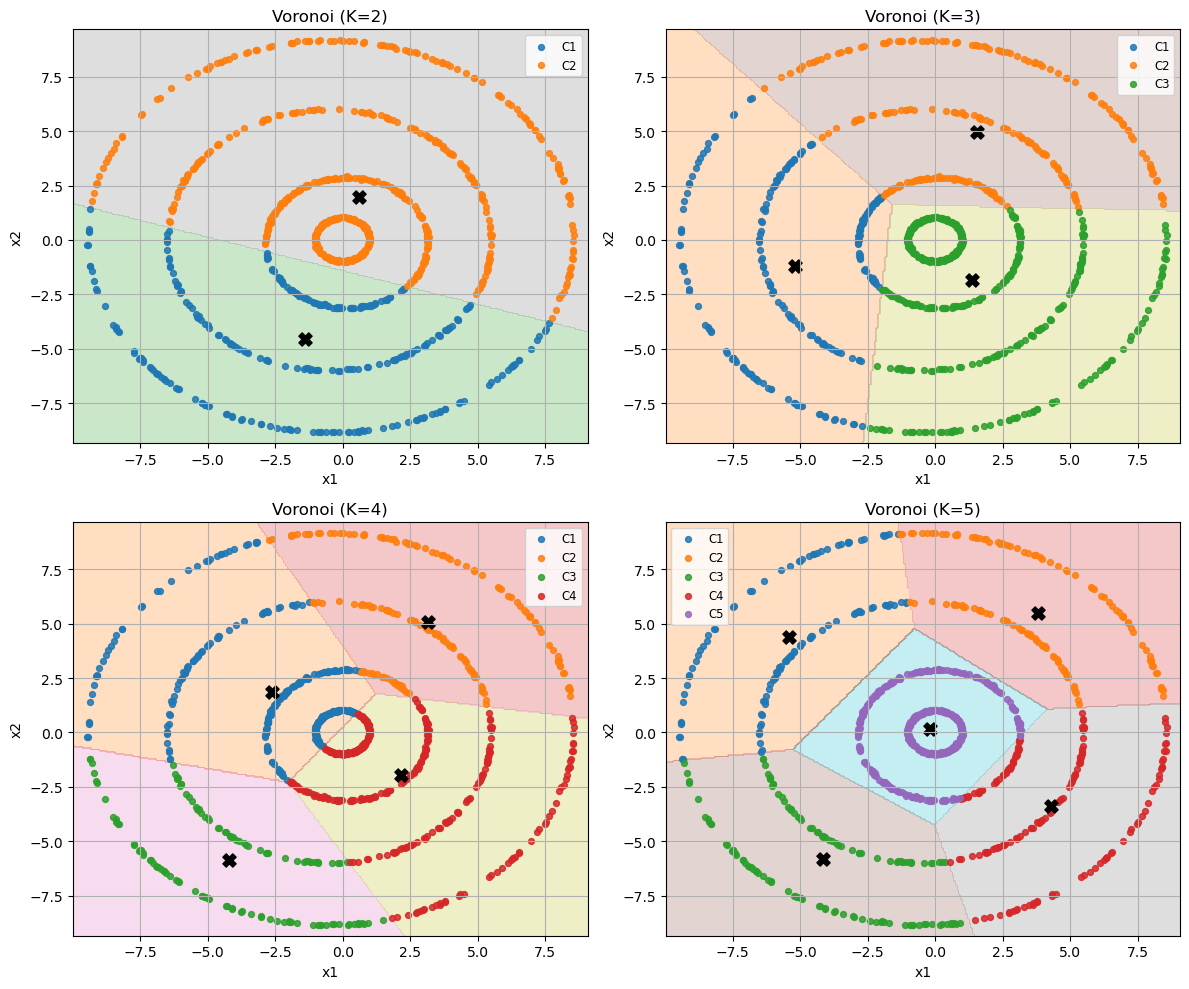

In [12]:
np.random.seed(42)
fixed_idx = np.random.choice(n, 5, replace=False)

Ks = [2,3,4,5]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

for i, K in enumerate(Ks):
    centersK, labelsK, _ = kmeans(X, K, init_centers=X[fixed_idx[:K]])
    plot_voronoi_like(axs[i], X, centersK, labelsK, title=f"Voronoi (K={K})")

plt.tight_layout()
plt.show()


## Part (b): Voronoi Regions

The data is made up of **concentric rings**, however the Voronoi cells form **linear borders** that do not match circular patterns.
- K=2 : Straight cut, rings are completely mixed.  
- K = 3 : Inner ring somewhat separated, outer rings split into wedges.  
- K=4:More clusters, but rings still divided into slices.  
- K=5:Smaller cells, slightly better, yet rings remain broken.  

### Final Note
Voronoi/K-Means cannot handle concentric rings due to **linear boundaries**.  
Non-linear approaches  are more effective at identifying the circular structure.

## Q2(c)

In [13]:
# computing pairwise squared distances
def pairwise_sq_dists(A, B):
    A2 = np.sum(A**2, axis=1)[:, None]
    B2 = np.sum(B**2, axis=1)[None, :]
    return A2 + B2 - 2 * A.dot(B.T)


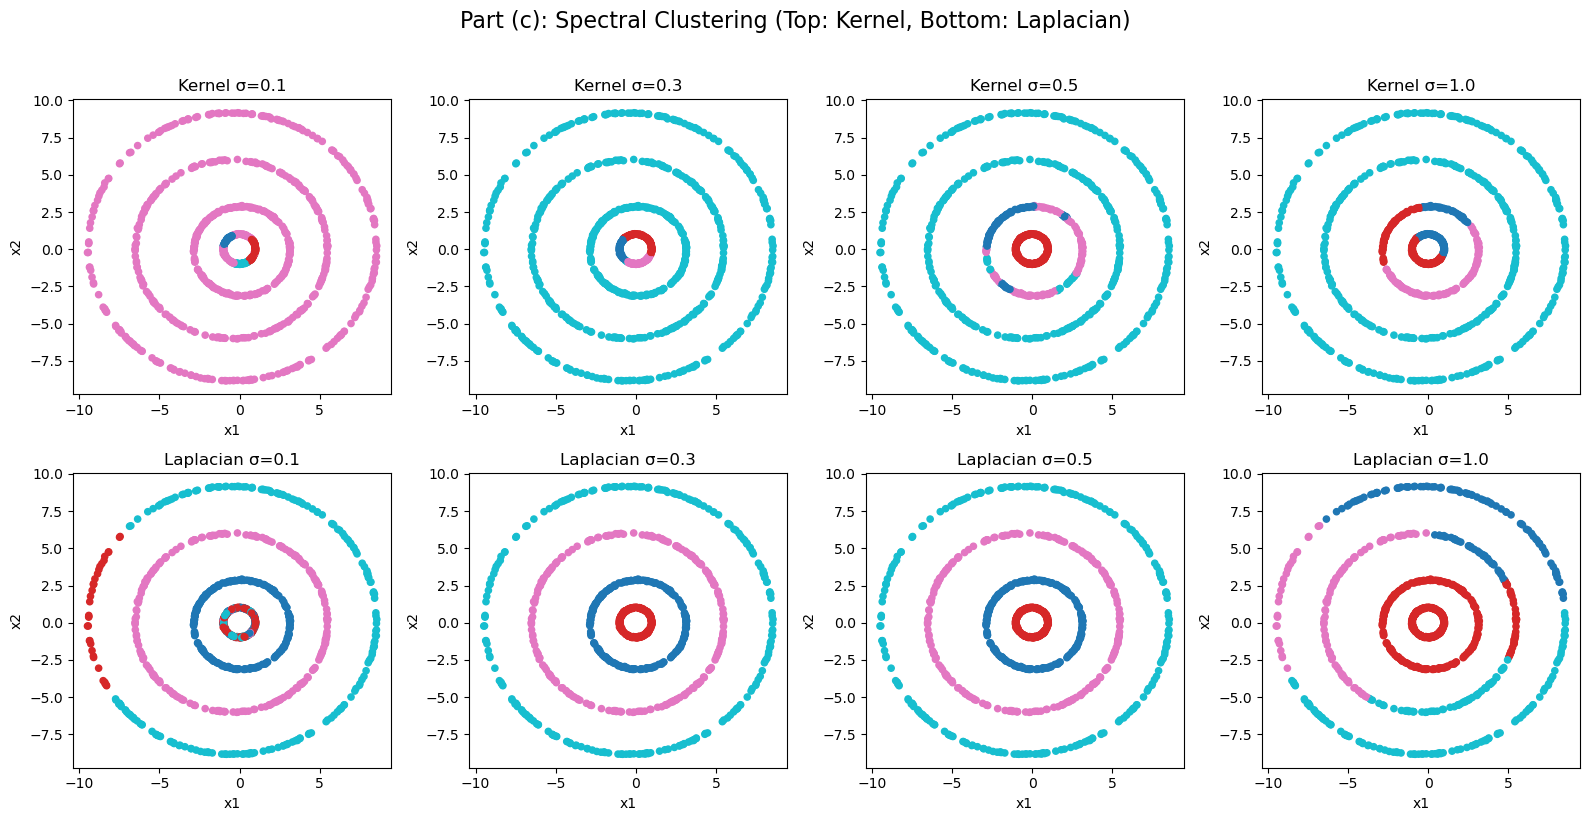

In [14]:
# Part (c): Kernel vs Laplacian spectral clustering  (row 0 = Kernel, row 1 = Laplacian)
sigmas = [0.1, 0.3, 0.5, 1.0]
k = 4

fig, axs = plt.subplots(2, 4, figsize=(16, 8))  

for col, sigma in enumerate(sigmas):
    sq_d = pairwise_sq_dists(X, X)

    # ----- Kernel-----
    gamma = 1.0 / (2 * sigma**2)
    K = np.exp(-gamma * sq_d)
    one_n = np.ones((n, n)) / n
    Kc = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    eigvals_K, eigvecs_K = np.linalg.eigh(Kc)
    idx = np.argsort(eigvals_K)[::-1]
    eigvecs_K = eigvecs_K[:, idx]
    V = eigvecs_K[:, :k]
    row_norms = np.linalg.norm(V, axis=1, keepdims=True)
    row_norms[row_norms == 0] = 1.0
    Y = V / row_norms
    _, labels_kernel, _ = kmeans(Y, k, seed=42)

    axs[0, col].scatter(X[:, 0], X[:, 1], c=labels_kernel, cmap='tab10', s=20)
    axs[0, col].set_title(f"Kernel σ={sigma}")
    axs[0, col].set_xlabel("x1"); axs[0, col].set_ylabel("x2")

    # ----- Laplacian  -----
    W = np.exp(-sq_d / (2 * sigma**2))
    deg = np.sum(W, axis=1)
    deg[deg == 0] = 1e-12
    D_inv_sqrt = np.diag(1.0 / np.sqrt(deg))
    L_sym = np.eye(n) - D_inv_sqrt @ W @ D_inv_sqrt
    eigvals_L, eigvecs_L = np.linalg.eigh(L_sym)
    idxL = np.argsort(eigvals_L)
    eigvecs_L = eigvecs_L[:, idxL]
    U = eigvecs_L[:, :k]
    row_norms = np.linalg.norm(U, axis=1, keepdims=True)
    row_norms[row_norms == 0] = 1.0
    U_norm = U / row_norms
    _, labels_lap, _ = kmeans(U_norm, k, seed=42)

    axs[1, col].scatter(X[:, 0], X[:, 1], c=labels_lap, cmap='tab10', s=20)
    axs[1, col].set_title(f"Laplacian σ={sigma}")
    axs[1, col].set_xlabel("x1"); axs[1, col].set_ylabel("x2")

plt.suptitle("Part (c): Spectral Clustering (Top: Kernel, Bottom: Laplacian)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Part (c): Spectral Clustering (Kernel PCA vs Laplacian)

### Kernel PCA (Top Row)
- For **σ = 0.1**, the rings are about to converge into a single one, that doesn't help us much.  
- For **σ = 0.3 or 0.5**, it’s a little better, but still mixing the 2nd and earlier rings together overall.  
- For **σ = 1.0**, nothing happens and the clustering overlaps again.  
👉 Kernel PCA is not stable there and can’t get a clear separation of the 4 rings.  

### Laplacian (Bottom Row)
- In case of **σ = 0.1**, clusters are all over the place and there is no continuity.  
- For **σ = 0.3 or 0.5** the 4 rings are visible very well.  
- For **σ= 1.0**, outer rings collate once more.  
👉 Laplacian is better, because best choice for σ is around 0.3–0.5.  

### Final Note
Kernel PCA is unable to find the 4 rings in this data set, while Laplacian clustering is able to retrieve them once a good choice of σ is made.  



## Q2(d) 

$$ [
    \ell(i) = \arg\max_{1 \leq j \leq k} v_{ji}.
     ] $$

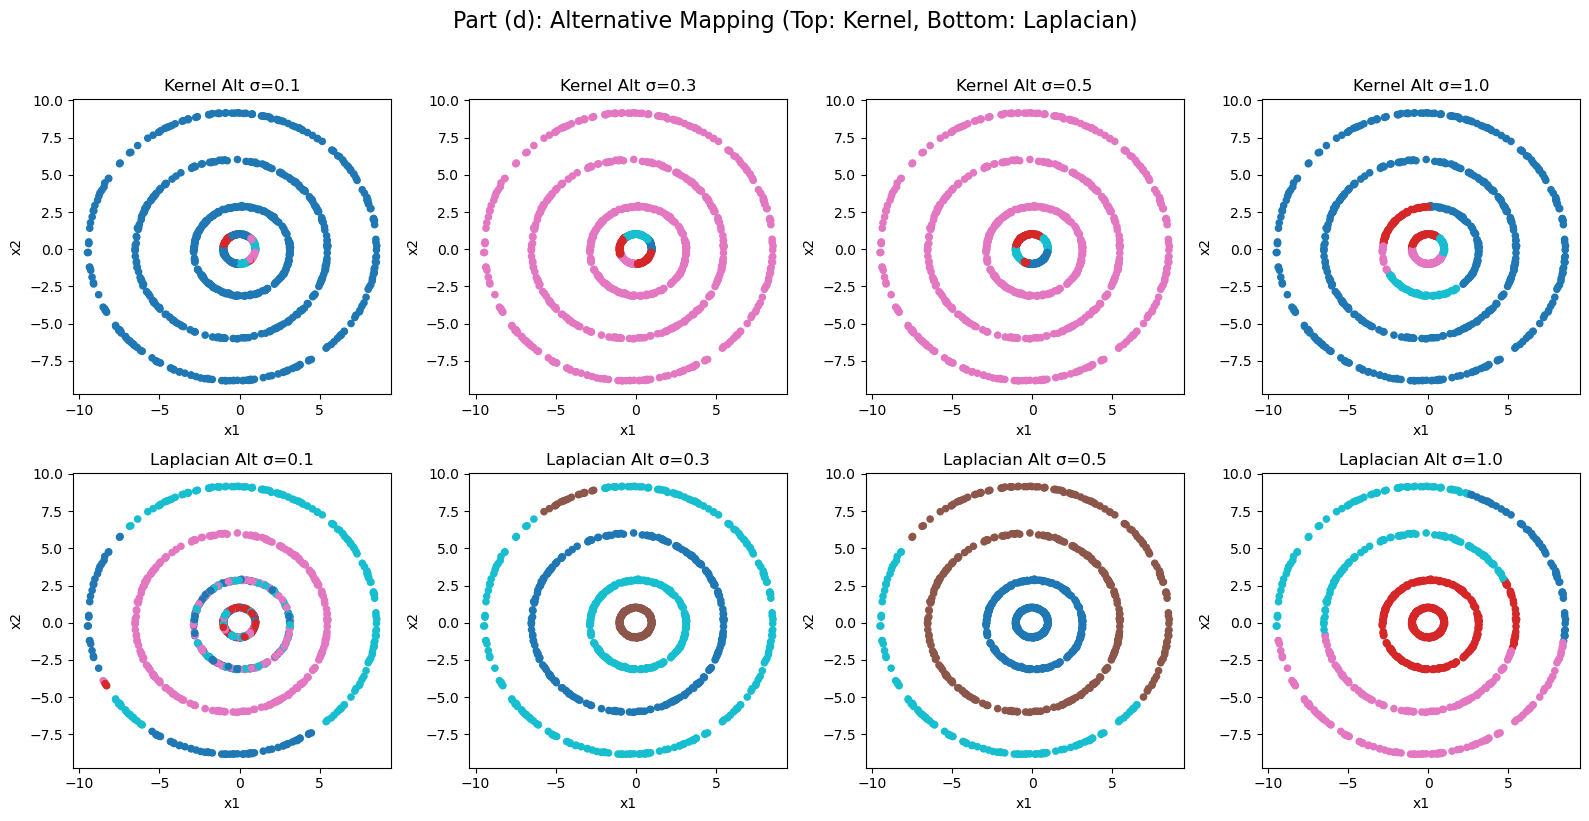

In [15]:
# Part (d): Kernel vs Laplacian alternative mapping (row 0 = Kernel, row 1 = Laplacian)
sigmas = [0.1, 0.3, 0.5, 1.0]
k = 4

fig, axs = plt.subplots(2, 4, figsize=(16, 8))  

for col, sigma in enumerate(sigmas):
    sq_d = pairwise_sq_dists(X, X)

    # ----- Kernel Alternative Mapping -----
    gamma = 1.0 / (2 * sigma**2)
    K = np.exp(-gamma * sq_d)
    one_n = np.ones((n, n)) / n
    Kc = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    eigvals_K, eigvecs_K = np.linalg.eigh(Kc)
    idx = np.argsort(eigvals_K)[::-1]
    eigvecs_K = eigvecs_K[:, idx]
    V = eigvecs_K[:, :k]
    labels_kernel_alt = np.argmax(V, axis=1)

    axs[0, col].scatter(X[:, 0], X[:, 1], c=labels_kernel_alt, cmap='tab10', s=20)
    axs[0, col].set_title(f"Kernel Alt σ={sigma}")
    axs[0, col].set_xlabel("x1"); axs[0, col].set_ylabel("x2")

    # ----- Laplacian Alternative Mapping -----
    W = np.exp(-sq_d / (2 * sigma**2))
    deg = np.sum(W, axis=1)
    deg[deg == 0] = 1e-12
    D_inv_sqrt = np.diag(1.0 / np.sqrt(deg))
    L_sym = np.eye(n) - D_inv_sqrt @ W @ D_inv_sqrt
    eigvals_L, eigvecs_L = np.linalg.eigh(L_sym)
    idxL = np.argsort(eigvals_L)
    eigvecs_L = eigvecs_L[:, idxL]
    U = eigvecs_L[:, :k]
    labels_lap_alt = np.argmax(U, axis=1)

    axs[1, col].scatter(X[:, 0], X[:, 1], c=labels_lap_alt, cmap='tab10', s=20)
    axs[1, col].set_title(f"Laplacian Alt σ={sigma}")
    axs[1, col].set_xlabel("x1"); axs[1, col].set_ylabel("x2")

plt.suptitle("Part (d): Alternative Mapping (Top: Kernel, Bottom: Laplacian)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Part (d): An Alternative Mapping (Kernel Vs. Laplacian)

Here I did the second mapping (argmax on eigenvectors) in lieu of one spectral K-Means run. We present the results for different σ.  


### Kernel Alt (Top Row)
- **σ = 0.1, 0.3, 0.5:** Nearly everything in the blends will go to one cluster, rings are not discreetified.  
- **σ = 1.0:** There is some variation, but the rings are still mixed together.  
👉 Kernel replacement mapping is more or less false for all cases.  


### Laplacian Alt (Bottom Row)
- **σ = 0.1:** Rings are partially broken, noisily.  
- **σ = 0.3 / 0.5:** Better than the kernel (rings are visible, but not really clear).  
- **σ = 1.0:** Inner as well as outer rings are visible but they overlap.  
👉 Laplacian performs better than kernel here, but it is still worse than K-Means on spectral embedding.  


### Final Note
Alternative mapping is less effective. Kernel does not work well, Laplacian is slightly better (σ ≈ 0.3–0.5), but K-Means in spectral space works the best.  

